In [1]:
#!/usr/bin/env python
from __future__ import print_function, division
# coding: utf-8

# In[1]:


import torch
import sys

# from torchvision import datasets, models, transforms

from PIL import Image
import torchvision

sys.path.append('/om5/user/smadan/training_scaffold_own/res/')
from models.models import get_model
from loader.loader import get_loader
import random
import pickle
import argparse

/net/storage001.ib.cluster/om2/user/smadan/differentiable_graphics_ml/training_models
/om5/user/smadan/training_scaffold_own/res/loader/multi_attribute_loader.py
/om5/user/smadan/training_scaffold_own/res/loader
/om5/user/smadan/training_scaffold_own/res/loader/loader.py
/om5/user/smadan/training_scaffold_own/res/loader


In [2]:
NUM_EPOCHS = 200
BATCH_SIZE = 100
MODEL_ARCH = 'simple_cnn'
NUM_CLASSES = 55
BASE_LR = 0.001
CUDA_DEVICE = 0
USE_GPU = 1
SAVE_PATH = ''
LOG_FILE = ''


loader = get_loader('multi_attribute_loader_file_list_shapenet')

In [3]:
# In[4]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import collections
from collections import OrderedDict
from tqdm import tqdm

In [4]:
DATASET_NAME = 'shapenet_debug'

In [5]:
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

loader_new = get_loader('multi_attribute_loader_file_list_shapenet')
file_list_root = '/om5/user/smadan/dataset_lists_openmind'
att_path = '/om5/user/smadan/differentiable_graphics_ml/training_models/shapenet_id_to_class_num.p'
shuffles = {'train':True,'val':True,'test':True}

if USE_GPU:
    torch.cuda.set_device(CUDA_DEVICE)

count=0

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
# data_dir = DATA_DIR
# dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
#          for x in ['train', 'test']}
# dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=BATCH_SIZE,
#                                                shuffle=True, num_workers=25)
#                 for x in ['train', 'test']}
# dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
# dset_classes = dsets['train'].classes


# In[13]:


################ GET FROM USER CONFIG - TODO #####################
file_lists = {}
dsets = {}
dset_loaders = {}
dset_sizes = {}
for phase in ['train','test']:
    file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,DATASET_NAME)
    dsets[phase] = loader_new(file_lists[phase],att_path, image_transform)
    dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=BATCH_SIZE, shuffle = shuffles[phase], num_workers=2,drop_last=True)
    dset_sizes[phase] = len(dsets[phase])

In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnormalize = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [12]:
with open('shapenet_class_num_to_class_name.p','rb') as F:
    shapenet_class_num_to_class_name = pickle.load(F)

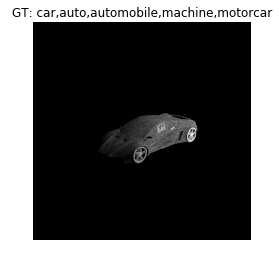

In [48]:
for data in dset_loaders['train']:
    break
    
ID = random.choice(range(10))
plt.imshow(unnormalize(data[0][ID]).permute(1,2,0))
gt = data[1][ID].item()
plt.title("GT: %s"%(shapenet_class_num_to_class_name[gt]))
plt.axis('off')
plt.show()

# Picking smaller Datasets

In [50]:
SHAPENET_DIR = '/om5/user/smadan/ShapeNetCore.v2/'

In [51]:
import os
import random
import pickle

In [52]:
categories = [i for i in os.listdir(SHAPENET_DIR) if '.json' not in i]

In [54]:
with open('/om5/user/smadan/differentiable_graphics_ml/allowed_categories.txt','r') as F:
    content = F.readlines()

In [67]:
sorted(allowed_categories)

['02691156',
 '02818832',
 '02958343',
 '03001627',
 '03467517',
 '03624134',
 '03790512',
 '03928116',
 '03948459',
 '04256520',
 '04379243']

In [57]:
allowed_categories = []
for c in content:
    c = c.rstrip()
    cat, _ = c.split(' ')
    allowed_categories.append(cat)

In [59]:
per_category_instances = {}

In [60]:
for category in categories:
    if category in allowed_categories:
        per_category_instances[category] = []
        instances = os.listdir("%s/%s"%(SHAPENET_DIR, category))
        for instance in instances:
            model_file = "%s/%s/%s/models/model_normalized.obj"%(SHAPENET_DIR, category, instance)
            per_category_instances[category].append(model_file)

In [61]:
sampled_per_category_instances = {}

In [77]:
for category in per_category_instances.keys():
    if len(per_category_instances[category]) > 50:
        chosen = random.sample(per_category_instances[category],50)
    else:
        chosen = per_category_instances[category]
    sampled_per_category_instances[category] = chosen

In [78]:
total = 0
for category in sampled_per_category_instances.keys():
    total += len(sampled_per_category_instances[category])

In [84]:
# model_file

'/om5/user/smadan/ShapeNetCore.v2//03001627/2f24021efe2ccfcc2db431502a680805/models/model_normalized.obj'

In [79]:
# rejected = ['/om5/user/smadan/ShapeNetCore.v2//02691156/261093138afff514d8d7812d176664b2/models/model_normalized.obj',
#             '/om5/user/smadan/ShapeNetCore.v2//02691156/f894972de285088da0896c4491cb3db6/models/model_normalized.obj',
#              '/om5/user/smadan/ShapeNetCore.v2//02691156/cda1206f9460ece9868255f726935f63/models/model_normalized.obj',
#             '/om5/user/smadan/ShapeNetCore.v2//02691156/733afba7f61652e789850bc84e2ce90e/models/model_normalized.obj',
#             '/om5/user/smadan/ShapeNetCore.v2//02691156/f39e0412290bcc714917e69390d054d0/models/model_normalized.obj',
#             '/om5/user/smadan/ShapeNetCore.v2//02691156/e3c26c3920b93f36eb7fefaef8eada2b/models/model_normalized.obj',
#            ]

In [81]:
# sampled_per_category_instances['02691156']

In [85]:
with open('/om5/user/smadan/differentiable_graphics_ml/rendering/chosen_models_20.pkl','rb') as F:
    x = pickle.load(F)

In [129]:
fol = '/om5/user/smadan/differentiable_graphics_ml/data/shapenet_rendered_hand_picked/'

In [130]:
all_ims = os.listdir(fol)

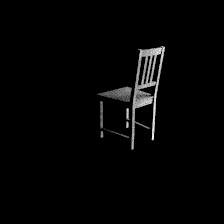

In [131]:
Image.open("%s/%s"%(fol,random.choice(all_ims)))

In [82]:
with open('/om5/user/smadan/differentiable_graphics_ml/rendering/categories_11_models_50.pkl','wb') as F:
    pickle.dump(sampled_per_category_instances, F)

In [70]:
cat_1_models = sampled_per_category_instances['02691156']

In [66]:
chosen[0].split('/')[7]

'63bd5dd05e693b762cc8c3d5fbecbcf1'

In [23]:
import cv2
import numpy as np

In [24]:
img = (np.array(data[0][ID].permute(1,2,0)))

NameError: name 'data' is not defined

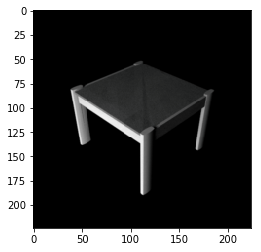

In [175]:
plt.imshow(img)

In [182]:
tonemapDurand = cv2.createTonemapDurand(1)
ldrDurand = tonemapDurand.process(img)

In [183]:
im2_8bit = np.clip(ldrDurand*255, 0, 255).astype('uint8')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


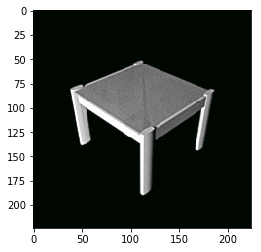

In [184]:
plt.imshow(ldrDurand)

In [195]:
fol = '/om5/user/smadan/differentiable_graphics_ml/data/shapenet_rendered_simple/'

In [196]:
ims = os.listdir(fol)

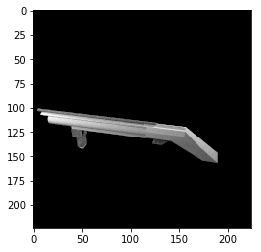

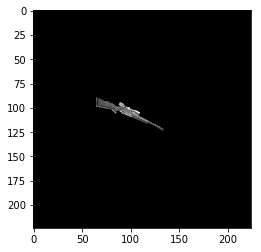

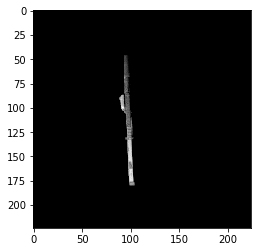

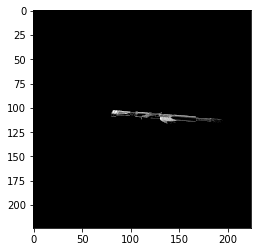

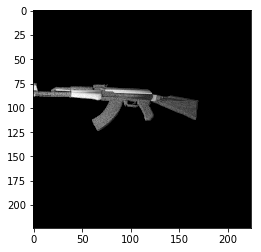

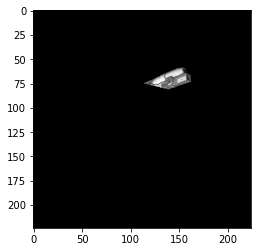

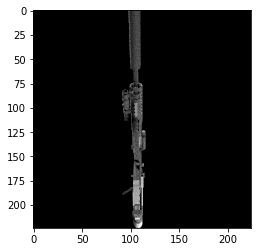

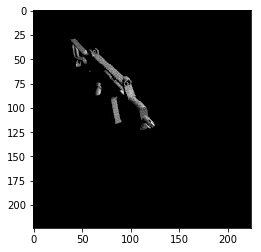

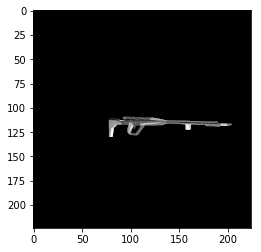

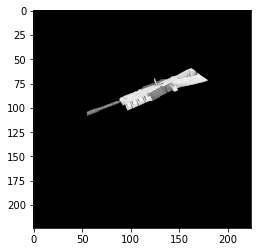

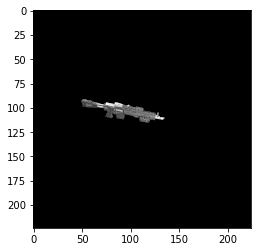

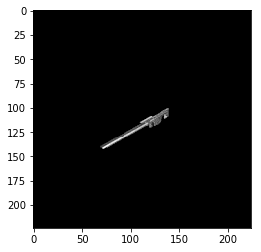

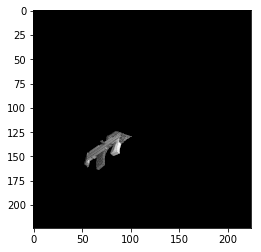

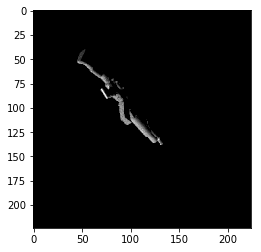

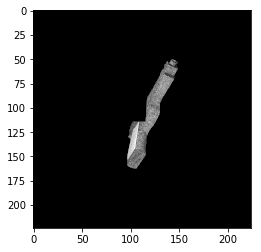

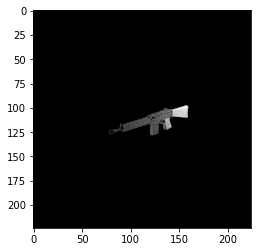

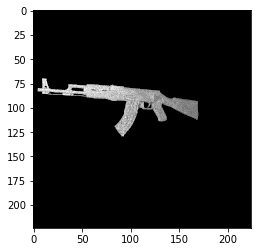

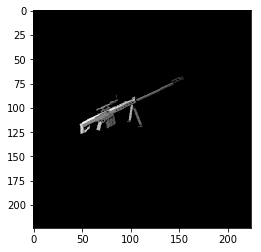

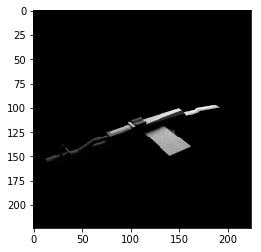

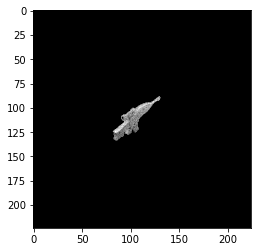

In [202]:
for i in range(1000,1020):
    plt.imshow(Image.open("%s/%s"%(fol,ims[i])))
    plt.show()